## The goal is to provide educational implementation of the [flash attention](https://arxiv.org/abs/2205.14135) forward pass

#### Reference from flash attention paper
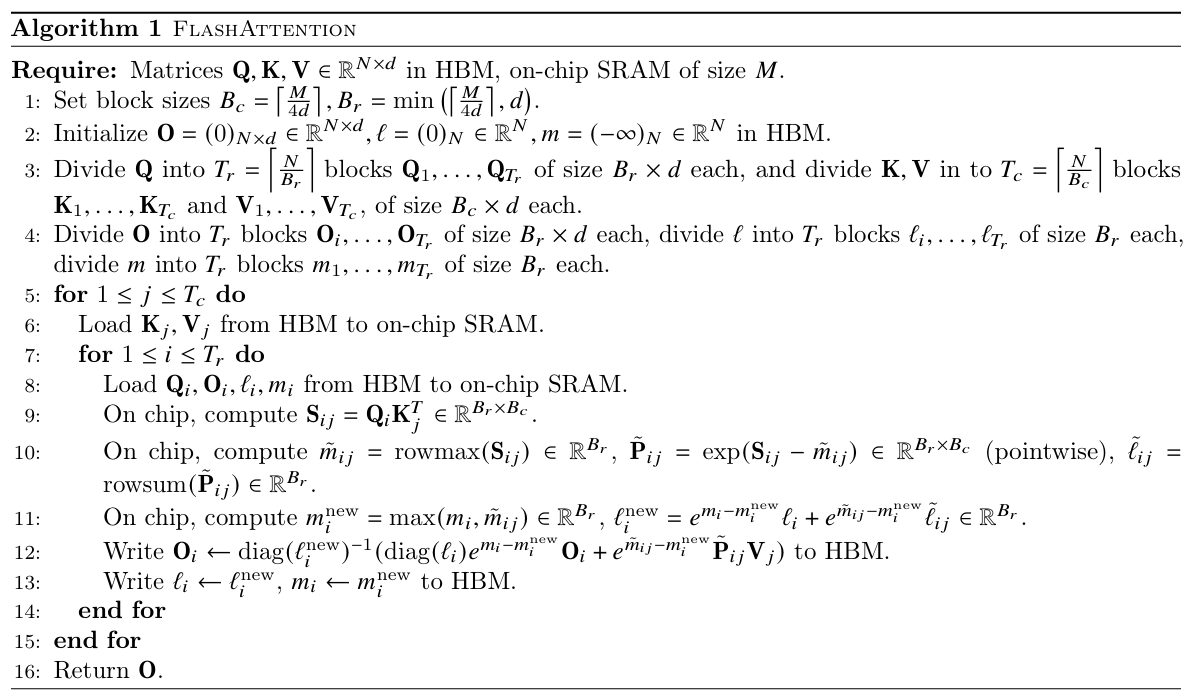

#### In our implementation, we use the following notation for shapes:
- `N` is the batch size
- `S` is the sequence length
- `D` is the head dimension

In [1]:
import torch


def naive_attn(q, k, v, scale):
    s = (
        q @ k.mT * scale
    )  # k.mT = torch.transpose(k, 1, 2) with k.shape = (N, S, D) = (batch, seq_len, head_dim)
    a = torch.softmax(s, dim=-1)
    return a @ v

In [2]:
# Algorithm 1 in the paper assumes 1 batch
# Algorithm 1 in the paper first do a foor loop over key value blocks,
# then a for loop over query blocks
# In the basic implementation, we do the opposite, first a for loop over query blocks,
# then a for loop over key value blocks
# This is better aligned for extensions, e.g., the ring attension


# Basic implementation of the Algorithm 1 in the paper,
# the steps are numbered according to the paper
def flash_attn_algo_1_basic(q, k, v, scale, block_size_q, block_size_k):
    q_batch, q_seq_len, q_dim = q.shape
    k_batch, k_seq_len, k_dim = k.shape
    assert q_batch == k_batch
    assert q_dim == k_dim

    output = torch.zeros(q_batch, q_seq_len, v.size(-1))

    for b in range(q_batch):
        # step over the queries
        for q_start in range(0, q_seq_len, block_size_q):
            q_end = min(q_start + block_size_q, q_seq_len)
            # load q rows
            q_block = q[b, q_start:q_end]

            effective_block_size_q = q_end - q_start
            cur_max = torch.full(
                size=(effective_block_size_q, 1),
                fill_value=torch.finfo(q.dtype).min,
            )
            cur_sum = torch.zeros(size=(effective_block_size_q, 1))

            for k_start in range(0, k_seq_len, block_size_k):
                k_end = min(k_start + block_size_k, k_seq_len)
                k_block = k[b, k_start:k_end]

                # Step 9
                # Compute dot, matrix multiplication of `q_block` and the transpose of `k_block`
                dots = torch.einsum(
                    "nd,md->nm", q_block, k_block
                )  # -> [block_size_q, blocksize_k]
                dots *= scale  # The scale is handeled in Algorithm 2 of the flash attention paper, Step 10
                # Step 10
                dots_max = dots.max(
                    dim=-1, keepdim=True
                ).values  # max operation along each row, -> [block_size_q, 1]

                dots = dots - dots_max
                dots_exp = (
                    dots.exp()
                )  # P_{ij} in Step 10, -> [block_size_q, blocksize_k]
                block_sum = dots_exp.sum(
                    dim=-1, keepdim=True
                )  # l{ij} in Step 10, -> [block_size_q, 1]

                new_max = torch.maximum(cur_max, dots_max)  # Step 11
                correction_factor = torch.exp(cur_max - new_max)  # [block_size_q, 1]
                correction_factor_block = torch.exp(
                    dots_max - new_max
                )  # [block_size_q, 1]
                new_sum = (
                    correction_factor * cur_sum + correction_factor_block * block_sum
                )  # Step 11, -> [block_size_q, 1]

                new_sum_squeezed = new_sum.squeeze(
                    1
                )  # Remove the dimension of size 1, -> [block_size_q]
                cur_sum_squeezed = cur_sum.squeeze(
                    1
                )  # Remove the dimension of size 1, -> [block_size_q]

                new_sum_diag_inv = torch.diag(
                    1.0 / new_sum_squeezed
                )  # Create a diagonal matrix with 1/new_sum on the diagonal
                cur_sum_diag = torch.diag(
                    cur_sum_squeezed
                )  # Create a diagonal matrix with cur_sum on the diagonal
                v_block = v[b, k_start:k_end]
                partial1 = (
                    correction_factor * cur_sum_diag @ output[b, q_start:q_end]
                )  # Step 12
                partial2 = correction_factor_block * (dots_exp @ v_block)  # Step 12
                output[b, q_start:q_end] = new_sum_diag_inv @ (
                    partial1 + partial2
                )  # Step 12

                cur_max = new_max  # Step 13
                cur_sum = new_sum  # Step 13

    return output

In [3]:
# In this implementation, we make the matrix multiplication with diagonal matrix in Step 12
# into element wise operation with broadcasting, the steps are numbered according to the paper
def flash_attn_algo_1_basic_v2(q, k, v, scale, block_size_q, block_size_k):
    q_batch, q_seq_len, q_dim = q.shape
    k_batch, k_seq_len, k_dim = k.shape
    assert q_batch == k_batch
    assert q_dim == k_dim

    output = torch.zeros(q_batch, q_seq_len, v.size(-1))

    for b in range(q_batch):
        # step over the queries
        for q_start in range(0, q_seq_len, block_size_q):
            q_end = min(q_start + block_size_q, q_seq_len)
            # load q rows
            q_block = q[b, q_start:q_end]

            effective_block_size_q = q_end - q_start
            cur_max = torch.full(
                size=(effective_block_size_q, 1),
                fill_value=torch.finfo(q.dtype).min,
            )
            cur_sum = torch.zeros(size=(effective_block_size_q, 1))

            for k_start in range(0, k_seq_len, block_size_k):
                k_end = min(k_start + block_size_k, k_seq_len)
                k_block = k[b, k_start:k_end]

                # Step 9
                # Compute dot, matrix multiplication of `q_block` and the transpose of `k_block`
                dots = torch.einsum(
                    "nd,md->nm", q_block, k_block
                )  # -> [block_size_q, blocksize_k]
                dots *= scale  # The scale is handeled in Algorithm 2 (step 10) of the flash attention paper

                # Step 10
                dots_max = dots.max(
                    dim=-1, keepdim=True
                ).values  # max operation along each row, -> [block_size_q, 1]

                dots = dots - dots_max
                dots_exp = (
                    dots.exp()
                )  # P_{ij} in Step 10, -> [block_size_q, blocksize_k]
                block_sum = dots_exp.sum(
                    dim=-1, keepdim=True
                )  # l{ij} in Step 10, -> [block_size_q, 1]

                new_max = torch.maximum(cur_max, dots_max)  # Step 11
                correction_factor = torch.exp(cur_max - new_max)
                correction_factor_block = torch.exp(dots_max - new_max)
                new_sum = (
                    correction_factor * cur_sum + correction_factor_block * block_sum
                )  # Step 11, -> [block_size_q, 1]

                v_block = v[b, k_start:k_end]
                partial1 = (
                    correction_factor * cur_sum * output[b, q_start:q_end]
                )  # Step 12
                partial2 = correction_factor_block * (dots_exp @ v_block)  # Step 12
                output[b, q_start:q_end] = (partial1 + partial2) / new_sum  # Step 12

                cur_max = new_max  # Step 13
                cur_sum = new_sum  # Step 13

    return output

In [4]:
# Neat version from andreaskoepf
def naive_flash_attn(q, k, v, scale, block_size_q, block_size_k):
    # compute softmax incrementally blockwise, correct at the end
    q_batch, q_seq_len, q_dim = q.shape
    k_batch, k_seq_len, k_dim = k.shape
    assert q_batch == k_batch
    assert q_dim == k_dim

    output = torch.zeros(q_batch, q_seq_len, v.size(-1))

    for b in range(q_batch):
        # step over the queries
        for q_start in range(0, q_seq_len, block_size_q):
            q_end = min(q_start + block_size_q, q_seq_len)
            # load q rows
            q_block = q[b, q_start:q_end]

            effective_block_size_q = q_end - q_start
            cur_max = torch.full(
                size=(effective_block_size_q, 1),
                fill_value=torch.finfo(q.dtype).min,
            )
            cur_sum = torch.zeros(size=(effective_block_size_q, 1))

            for k_start in range(0, k_seq_len, block_size_k):
                k_end = min(k_start + block_size_k, k_seq_len)
                k_block = k[b, k_start:k_end]

                # compute dot
                dots = torch.einsum(
                    "nd,md->nm", q_block, k_block
                )  # -> [block_size_q, blocksize_k]
                dots *= scale
                dots_max = dots.max(dim=-1, keepdim=True).values
                new_max = torch.maximum(cur_max, dots_max)

                dots = dots - new_max
                dots_exp = dots.exp()
                block_sum = dots_exp.sum(dim=-1, keepdim=True)

                if k_start > 0 and torch.any(new_max > cur_max):
                    correction_factor = torch.exp(cur_max - new_max)
                    output[b, q_start:q_end] = (
                        output[b, q_start:q_end] * correction_factor
                    )
                    cur_sum = correction_factor * cur_sum

                cur_sum += block_sum
                cur_max = new_max

                # multiply with values and add
                v_block = v[b, k_start:k_end]
                o = dots_exp @ v_block
                output[b, q_start:q_end] += o

            # final scaling of values
            output[b, q_start:q_end] /= cur_sum

    return output

In [5]:
def flash_attn_algo_1_basic_v2_incremental_k_block(
    q_block, k_block, v_block, scale, cur_max, cur_sum, output_block
):
    # Step 9
    # Compute dot, matrix multiplication of `q_block` and the transpose of `k_block`
    dots = torch.einsum("nd,md->nm", q_block, k_block)  # -> [block_size_q, blocksize_k]
    dots *= scale  # The scale is handeled in Algorithm 2 (step 10) of the flash attention paper

    # Step 10
    dots_max = dots.max(
        dim=-1, keepdim=True
    ).values  # max operation along each row, -> [block_size_q, 1]

    dots = dots - dots_max
    dots_exp = dots.exp()  # P_{ij} in Step 10, -> [block_size_q, blocksize_k]
    block_sum = dots_exp.sum(
        dim=-1, keepdim=True
    )  # l{ij} in Step 10, -> [block_size_q, 1]

    new_max = torch.maximum(cur_max, dots_max)  # Step 11
    correction_factor = torch.exp(cur_max - new_max)
    correction_factor_block = torch.exp(dots_max - new_max)
    new_sum = (
        correction_factor * cur_sum + correction_factor_block * block_sum
    )  # Step 11, -> [block_size_q, 1]

    partial1 = correction_factor * cur_sum * output_block  # Step 12
    partial2 = correction_factor_block * (dots_exp @ v_block)  # Step 12
    output_block = (partial1 + partial2) / new_sum  # Step 12

    return output_block, new_max, new_sum

#### In this implementation, we extend the basic implementation to support incremental updates
#### based on algo_1_basic_v2 above

In [6]:
import random


def flash_attn_algo_1_basic_v2_incremental(
    q,
    k,
    v,
    scale,
    block_size_q,
    block_size_k,
):
    q_batch, q_seq_len, q_dim = q.shape
    k_batch, k_seq_len, k_dim = k.shape
    assert q_batch == k_batch
    assert q_dim == k_dim

    output = torch.zeros(q_batch, q_seq_len, v.size(-1))

    for b in range(q_batch):
        # step over the queries
        for q_start in range(0, q_seq_len, block_size_q):
            q_end = min(q_start + block_size_q, q_seq_len)
            # load q rows
            q_block = q[b, q_start:q_end]

            effective_block_size_q = q_end - q_start
            cur_max = torch.full(
                size=(effective_block_size_q, 1),
                fill_value=torch.finfo(q.dtype).min,
            )
            cur_sum = torch.zeros(size=(effective_block_size_q, 1))

            index_k_max = (k_seq_len + block_size_k - 1) // block_size_k
            indices = list(range(index_k_max))
            # Randomly shuffle the list, the results should be invariant to the order
            random.shuffle(indices)
            print(
                "For batch = %d and q_block start index = %d, the k,v blocks are updated according to indices:"
                % (b, q_start),
                indices,
            )
            for block_index_k in indices:
                # Determine the start and end of the k block
                k_start = block_index_k * block_size_k
                k_end = min(k_start + block_size_k, k_seq_len)
                k_block = k[b, k_start:k_end]
                # Extract the block from k
                k_block = k[b, k_start:k_end]
                v_block = v[b, k_start:k_end]
                (
                    output[b, q_start:q_end],
                    cur_max,
                    cur_sum,
                ) = flash_attn_algo_1_basic_v2_incremental_k_block(
                    q_block,
                    k_block,
                    v_block,
                    scale,
                    cur_max,
                    cur_sum,
                    output[b, q_start:q_end],
                )

    return output

In [7]:
def main():
    N, S, D = 2, 64, 128
    scale = D**-0.5

    q = torch.randn(N, S, D)
    k = torch.randn(N, S, D)
    v = torch.randn(N, S, D)

    o1 = naive_attn(q, k, v, scale)
    o2 = naive_flash_attn(q, k, v, scale, block_size_q=8, block_size_k=9)
    o3 = flash_attn_algo_1_basic(q, k, v, scale, block_size_q=8, block_size_k=9)
    o4 = flash_attn_algo_1_basic_v2(q, k, v, scale, block_size_q=8, block_size_k=9)
    o5 = flash_attn_algo_1_basic_v2_incremental(
        q, k, v, scale, block_size_q=8, block_size_k=9
    )

    print(
        "delta naive attn vs naive flash attn:",
        torch.abs(o1 - o2).sum(),
    )
    print(
        "delta naive attn vs flash attn algo 1 basic:",
        torch.abs(o1 - o3).sum(),
    )
    print(
        "delta naive attn vs flash attn algo 1 basic v2:",
        torch.abs(o1 - o4).sum(),
    )
    print(
        "delta naive attn vs flash attn algo 1 basic v2 incremental:",
        torch.abs(o1 - o5).sum(),
    )


if __name__ == "__main__":
    main()

For batch = 0 and q_block start index = 0, the k,v blocks are updated according to indices: [1, 6, 7, 4, 2, 3, 5, 0]
For batch = 0 and q_block start index = 8, the k,v blocks are updated according to indices: [6, 7, 3, 2, 1, 4, 0, 5]
For batch = 0 and q_block start index = 16, the k,v blocks are updated according to indices: [5, 1, 7, 0, 2, 4, 6, 3]
For batch = 0 and q_block start index = 24, the k,v blocks are updated according to indices: [7, 3, 5, 0, 4, 1, 2, 6]
For batch = 0 and q_block start index = 32, the k,v blocks are updated according to indices: [7, 0, 2, 1, 4, 5, 3, 6]
For batch = 0 and q_block start index = 40, the k,v blocks are updated according to indices: [3, 1, 4, 0, 7, 5, 6, 2]
For batch = 0 and q_block start index = 48, the k,v blocks are updated according to indices: [1, 0, 5, 6, 2, 3, 4, 7]
For batch = 0 and q_block start index = 56, the k,v blocks are updated according to indices: [2, 4, 0, 1, 3, 5, 7, 6]
For batch = 1 and q_block start index = 0, the k,v blocks 